# Chapter 6

In [1]:
library(rethinking)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.7, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan

Loading required package: parallel

rethinking (Version 2.21)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘package:stats’:

    rstudent




Easy questions are mostly repeating the book

### 6M2.
Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among
predictors before including them in a model. This is a bad procedure, because what matters is the
conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation
between X and Z is very large. Then include both in a model prediction Y. Do you observe any
multicollinearity? Why or why not? What is different from the legs example in the chapter?


In [2]:
N <- 100
x_sim <- rnorm(N)
z_sim <- rnorm(N, x_sim*4)
y_sim <- rnorm(N, z_sim*1)

In [3]:
d <- data.frame(X=x_sim, Z=z_sim, Y=y_sim)

In [4]:
head(d)

,X,Z,Y
,<dbl>,<dbl>,<dbl>
1,-0.8677131,-2.98104736,-0.90575937
2,-0.9855912,-4.70192580,-5.11103067
3,-0.1162020,-1.46139074,-0.71583590
4,-0.1422145,-0.06439281,-0.39812882
5,-0.5190734,0.07472869,0.07672176
6,0.5499179,1.24717293,1.43103082


In [5]:
m <- quap(
    alist(
        Y ~ dnorm(mu, sigma),
        mu <- bx*X + bz*Z + a,
        a ~ dnorm(0,2),
        bz ~ dnorm(1,2),
        bx ~ dnorm(4,2),
        sigma ~ exp(1)
        )
    ,data=d)

In [6]:
precis(m)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.001484562,0.2714815,-0.4323953,0.4353644
bz,0.738341173,0.2500906,0.3386481,1.1380342
bx,1.060199482,0.9785146,-0.5036558,2.6240548


here bx overlaps 0, but the model is fairly certain about bz's contribution, which is just like stated. This is different from the legs example because in the legs example the DAG would have a confounding parameter that connects the left leg length to the right leg length but here it's a pipe

### 6M3.
Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

**Answer**

1) top left paths 
    - X <- Z -> Y , open, condition on Z will break the path, we have a fork here
    - X <- Z <- A -> Y , open, condition on Z will break the path as we have a pipe, breaking Z will allow X and A to be conditionally independent 


In [7]:
library(dagitty)

In [8]:
dag_left_top <- dagitty( "dag { 
    X -> Y
    X <- Z -> Y
    X <- Z <- A -> Y
}" )

In [9]:
adjustmentSets(dag_left_top, exposure = 'X', outcome='Y')

{ Z }

2. top right paths
  - X -> Z -> Y, indirect effect to Y, should be included when estimating the total effect of X on Y, this is not a backdoor as there is no arrow entering X 
  - X -> Z <- A -> Y, closed as there is a collider

In [10]:
dag_right_top <- dagitty( "dag { 
    X -> Y
    X -> Z -> Y
    X -> Z <- A -> Y
}" )
adjustmentSets(dag_right_top, exposure = 'X', outcome = 'Y')

 {}

3. bottom left paths
 - X <- A -> Z <- Y, closed
 - X -> Z <- Y, closed

4. bottom right paths
 - X <- A -> Z -> Y # we have a fork, so conditioning on A will work, or Z for a pipe
 - X -> Z -> Y # indirect path

In [11]:
dag_bottom_right <- dagitty ( "dag {
    X -> Y
    X <- A -> Z -> Y
    X -> Z -> Y
}")
adjustmentSets(dag_bottom_right, exposure = 'X', outcome = 'Y')

{ A }

### 6H1.
Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

In [13]:
data(WaffleDivorce)

In [14]:
d <- WaffleDivorce

In [15]:
#standardize the data
d$D <- standardize(d$Divorce)
d$M <- standardize(d$Marriage)
d$A <- standardize(d$MedianAgeMarriage)

Just use the dag in the book, see 6.4.3

This means we condition on S

In [24]:
d

Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,D,M,A
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,4.5e-01,1.65420530,0.022644060,-0.60628951
Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0e+00,1.54436431,1.549801620,-0.68669925
Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0e+00,0.61071590,0.048974363,-0.20424076
Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,2.6e-01,2.09356925,1.655122831,-1.41038699
California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.0e+00,-0.92705795,-0.266989270,0.59985673
Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.0e+00,1.05007986,0.891544051,-0.28465051
Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.0e+00,-1.64102438,-0.793595325,1.24313471
Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,1.6e-02,-0.43277350,0.786222840,0.43903723
District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.0e+00,-1.86070636,-0.635613508,2.93173944


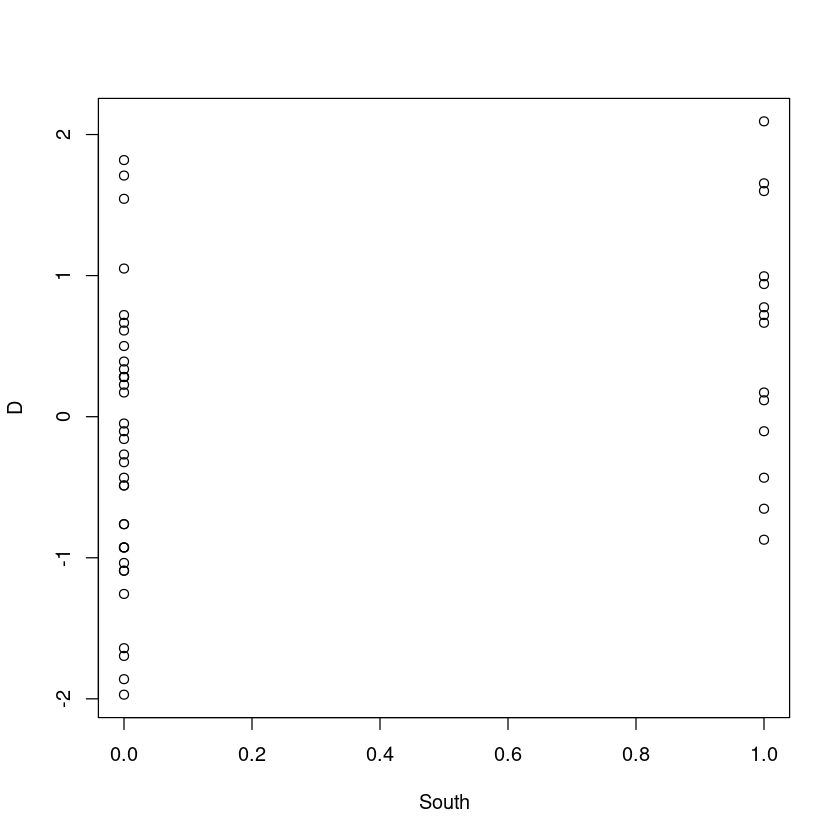

In [27]:
plot(D ~ South, data=d)

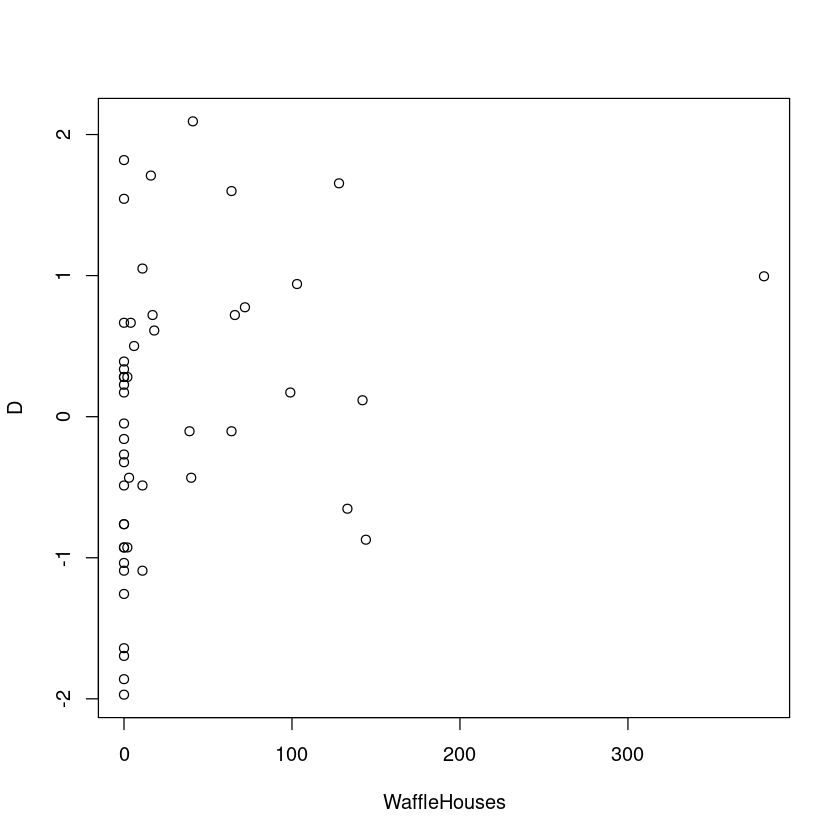

In [26]:
plot(D ~ WaffleHouses , data=d)

In [29]:
m <- quap (
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a+bs*South + bw*WaffleHouses,
        a ~ dnorm(0,0.2),
        bs ~ dnorm(0,0.5),
        bw ~ dnorm(0, 0.5),
        sigma ~ exp(1)
        )
    ,data=d)
        

In [30]:
precis(m)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.024406526,0.181579517,-0.314605664,0.26579261
bs,0.092439598,0.456721362,-0.637489350,0.82236855
bw,0.002743003,0.005931737,-0.006737058,0.01222306


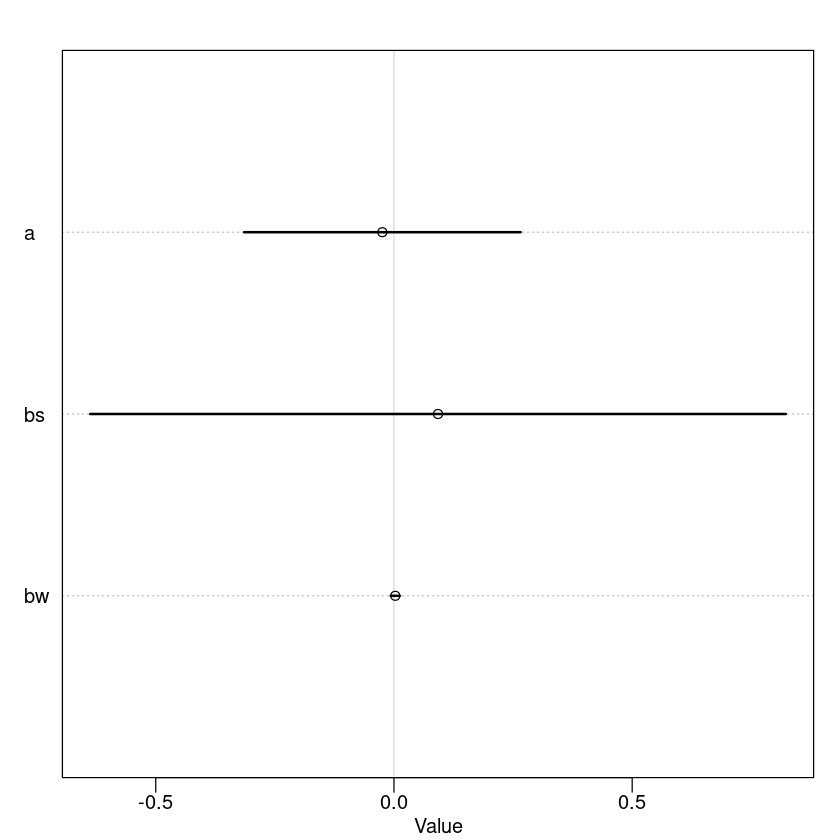

In [31]:
plot(precis(m))

This shows that there are no casual impact from waffle house to divorce rate. 

### 6H2.

Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data


let's just do one

A _ ||_ W | S

In [36]:
m <- quap(
    alist(
        A ~ dnorm(mu, sigma),
        mu <- a+bs*South + bw*WaffleHouses,
        a ~ dnorm(0,0.2),
        bs ~ dnorm(0,0.5),
        bw ~ dnorm(0, 0.5),
        sigma ~ exp(1)
        )
    ,data=d)

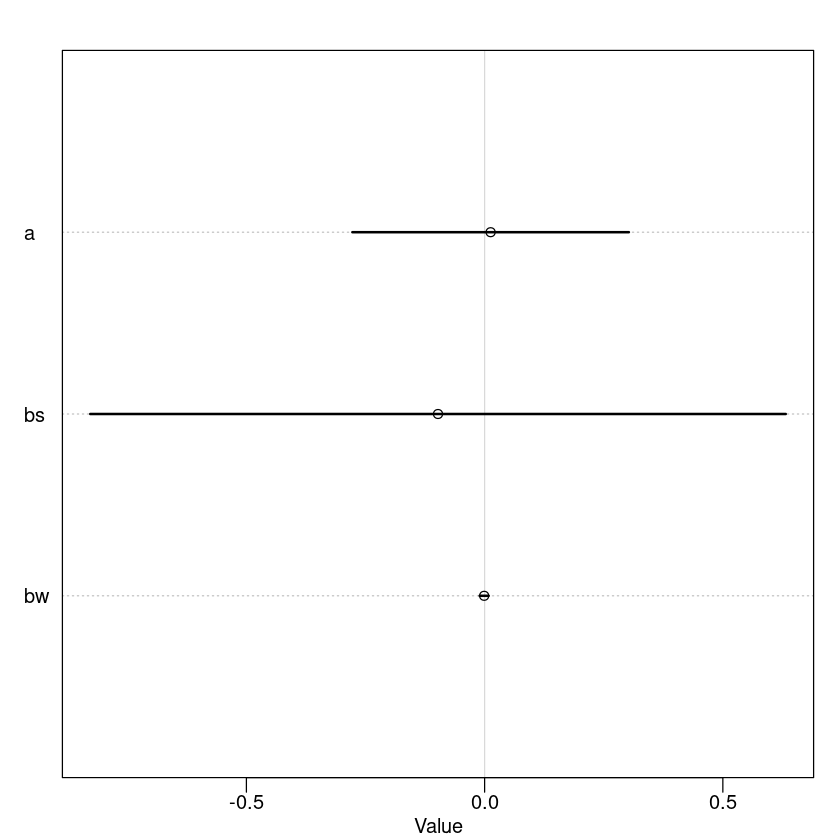

In [37]:
plot(precis(m))

In [38]:
precis(m)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.0125873849,0.181579517,-0.27761175,0.302786524
bs,-0.0978523631,0.456721362,-0.82778131,0.632076584
bw,-0.0009799867,0.005931737,-0.01046005,0.008500074


so bw is almost 0, therefore independent

### 6H3.

Use a model to infer the total causal influence of area on weight. Would increasing the area
available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the
possible outcome range

#### Answer 
 To find the total causal impact of area on weight, we simply regress weight on area with no conditioning. This is because the effect of area on weight is mediated through the other variables.

In [40]:
data(foxes)

In [41]:
d <- foxes

In [50]:
head(d)

,group,avgfood,groupsize,area,weight,A,W
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.37,2,1.09,5.02,-2.239596,0.4141347
2,1,0.37,2,1.09,2.84,-2.239596,-1.4270464
3,2,0.53,2,2.05,5.33,-1.205508,0.6759540
4,2,0.53,2,2.05,6.07,-1.205508,1.3009421
5,3,0.49,2,2.12,5.85,-1.130106,1.1151348
6,3,0.49,2,2.12,3.25,-1.130106,-1.0807692


In [43]:
head(d)

,group,avgfood,groupsize,area,weight
,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1,0.37,2,1.09,5.02
2,1,0.37,2,1.09,2.84
3,2,0.53,2,2.05,5.33
4,2,0.53,2,2.05,6.07
5,3,0.49,2,2.12,5.85
6,3,0.49,2,2.12,3.25


In [45]:
d$A <- standardize(d$area)
d$W <- standardize(d$weight)

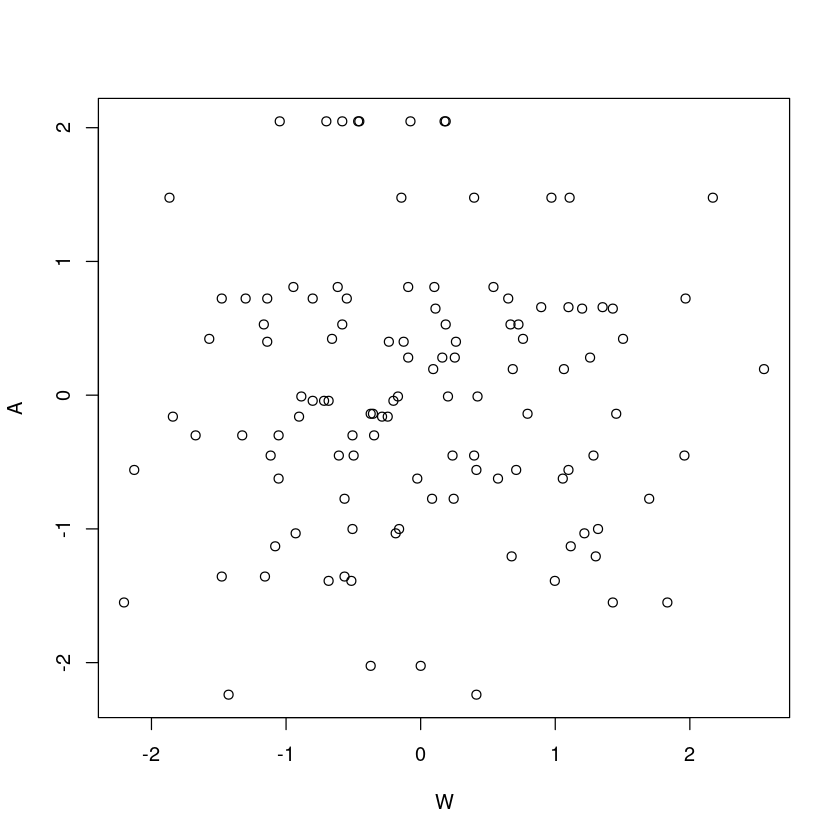

In [47]:
plot( A ~ W, d)

In [48]:
m <- quap(
    alist(
        a ~ dnorm(mu, sigma),
        mu <- a + bw*W,
        a ~ dnorm(0,0.5),
        bw ~ dnorm(0, 0.5),
        sigma ~ exp(1)
        ), data = d)

In [49]:
precis(m)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,6.149592e-08,0.5000000,-0.7990965,0.7990966
bw,-4.016933e-09,0.2260873,-0.3613311,0.3613311


No effect

### 6H4.
Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

#### Answer 
 There are no confounding backdoors between average food and weight in this model. Therefore no adjustments need to be made, and we can simply regress weight onto food without any further complications.


In [51]:
m <- quap(
    alist(
        a ~ dnorm(mu, sigma),
        mu <- a + bf*avgfood,
        a ~ dnorm(0,0.5),
        bf ~ dnorm(0, 0.5),
        sigma ~ exp(1)
        ), data = d)

In [53]:
precis(m)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,4.252016e-05,0.5000000,-0.7990540,0.7991391
bf,3.463492e-05,0.2723333,-0.4352065,0.4352758


also not much of an effect

### 6H5.
Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

#### Answer

In this case, the effect of groupsize on weight is confounded by the average food in the territory so we need to control for average food in this model.

In [54]:
m <- quap(
    alist(
        a ~ dnorm(mu, sigma),
        mu <- a + bf*avgfood+bg*groupsize,
        a ~ dnorm(0,0.5),
        bf ~ dnorm(0, 0.5),
        bg ~ dnorm(0, 0.5),
        sigma ~ exp(1)
        ), data = d)

In [56]:
precis(m)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-7.442480e-05,0.50000000,-0.7991710,0.7990221
bf,-4.148538e-05,0.48055219,-0.7680567,0.7679737
bg,1.008627e-05,0.09609461,-0.1535677,0.1535878


no effect at all?